In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Get dataset to train

In [3]:
import json
import torch    #if error, restart kernel
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import glob
import pandas as pd

import os

Fs = 100  # Sampling frequency

# Path to the folder containing the CSV files
folder_path = "TFO Data" + os.sep + "PPG" + os.sep + "Clean PPG"

# Get the list of CSV files in the folder
file_list = glob.glob(folder_path + os.sep + "*.csv")
file_path = file_list[0]

# Read the CSV file into a pandas dataframe
df = pd.read_csv(file_path)
#df = df[df.columns[2:-1]]  # Remove the time, index, and temperature columns
    
# Show the head of the dataframe
title = file_path.split(os.sep)[-1]
print(title)
print(df.shape)
df.head()

HR5.csv
(100880, 10)


,Ch1volts_WL1,Ch2volts_WL1,Ch3volts_WL1,Ch4volts_WL1,Ch5volts_WL1,Ch1volts_WL2,Ch2volts_WL2,Ch3volts_WL2,Ch4volts_WL2,Ch5volts_WL2
0,0.000002,7.564065e-09,7.688232e-10,2.700668e-11,1.013171e-12,4.776634e-07,2.232868e-09,1.269060e-10,1.522446e-12,7.479146e-15
1,0.000002,7.665455e-09,7.925804e-10,2.713974e-11,1.024571e-12,4.820643e-07,2.434110e-09,1.396813e-10,1.684177e-12,8.731407e-15
2,0.000002,7.781827e-09,8.180843e-10,2.729330e-11,1.037550e-12,4.869506e-07,2.651351e-09,1.535658e-10,1.861490e-12,1.022233e-14
3,0.000002,7.915956e-09,8.455011e-10,2.747432e-11,1.052474e-12,4.923786e-07,2.885586e-09,1.686320e-10,2.055546e-12,1.199234e-14
4,0.000002,8.070642e-09,8.749856e-10,2.769216e-11,1.069695e-12,4.983937e-07,3.137841e-09,1.849547e-10,2.267545e-12,1.408747e-14


### Normalize data in dataframe

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

columns = df.columns
index = df.index

# Normalize the data
scaler = StandardScaler() # Can't use this with BCELoss
#scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=columns, index=index)
df.head()

,Ch1volts_WL1,Ch2volts_WL1,Ch3volts_WL1,Ch4volts_WL1,Ch5volts_WL1,Ch1volts_WL2,Ch2volts_WL2,Ch3volts_WL2,Ch4volts_WL2,Ch5volts_WL2
0,-0.924712,-0.769320,-0.557761,-0.717445,-0.721082,-0.627808,-0.739798,-0.708603,-0.689157,-0.802517
1,-0.871856,-0.763291,-0.537699,-0.710557,-0.709649,-0.608375,-0.733747,-0.699651,-0.679949,-0.801749
2,-0.803797,-0.756371,-0.516162,-0.702609,-0.696632,-0.586797,-0.727215,-0.689922,-0.669854,-0.800834
3,-0.720341,-0.748394,-0.493009,-0.693240,-0.681665,-0.562828,-0.720172,-0.679365,-0.658806,-0.799747
4,-0.623300,-0.739195,-0.468111,-0.681965,-0.664393,-0.536266,-0.712587,-0.667927,-0.646736,-0.798462


In [5]:
x = df['Ch1volts_WL1']
y = df['Ch2volts_WL1']
print(x.shape)
print(y.shape)

(100880,)
(100880,)


## Create model and dataloaders

In [6]:
from Utils.models import VAE
from Utils.dataloader import DataLoaderGenerator
from Utils.processing import window_data

# Window the data
# data = window_data(x, 100)
data_x = window_data(x, 100)
data_y = window_data(y, 100)
# print(f"Data shape: {data.shape}")
print(f"Data shape: {data_x.shape}")
print(f"Data shape: {data_y.shape}")

# Create a DataLoader object
#dataloader = DataLoaderGenerator(data, batch_size=32)
dataloader = DataLoaderGenerator([data_x, data_y], batch_size=32)
#train_loader, val_loader = dataloader.generate()
train_loader = dataloader.generate()
print(f"Number of batches: {len(train_loader)}")

# Initialize the model
vae = VAE(input_dims=100, latent_dims=6)#, device='cpu')


Data shape: (100781, 100)
Data shape: (100781, 100)
Number of batches: 6298


In [7]:
from torchsummary import summary
if torch.cuda.is_available():
    vae = vae.to('cuda')
print(vae)
summary(vae, (1, 100))

VAE(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(31,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(21,))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(11,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv1d(128, 512, kernel_size=(4,), stride=(2,), padding=(5,))
    (10): LeakyReLU(negative_slope=0.01)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=12288, out_features=24, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=24, bias=True)
    (1): LeakyReLU(negat

## Train Model

In [8]:
train_save = False
if train_save:
    # Train the model
    vae.train_model(train_loader, n_epochs=10)
    # Save the model
    vae.save_model("Weights/vae_ppg.pth")
else:
    # Load the model
    vae.load_model("Weights/vae_ppg.pth")
    vae.eval()

### Loss Analysis

In [9]:
if train_save:
    vae.plot_loss()

## Create LSTM data and model

In [10]:
encoded_training_data = vae.encode_data(train_loader)

In [11]:
print(encoded_training_data.shape)

(201536, 6)


In [12]:
# Create a DataLoader object
lstm_dataloader = DataLoaderGenerator(encoded_training_data, batch_size=32)
#train_loader_lstm, val_loader_lstm = lstm_dataloader.generate()
train_loader_lstm = lstm_dataloader.generate()

In [13]:
train_loader_lstm.dataset.tensors[0].shape

torch.Size([201536, 1, 6])

In [14]:
from Utils.models import LSTM
from torchinfo import summary as summary2

lstm = LSTM()
if torch.cuda.is_available():
    lstm = lstm.to('cuda')
print(lstm)
summary2(lstm, input_size=(1, 6))

LSTM(
  (models): ModuleList(
    (0): LSTM(6, 64, batch_first=True)
    (1): LSTM(64, 64, batch_first=True)
    (2): LSTM(64, 6, batch_first=True)
    (3): Linear(in_features=6, out_features=6, bias=True)
  )
)


Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 6]                    --
├─ModuleList: 1-1                        --                        --
│    └─LSTM: 2-1                         [1, 64]                   18,432
│    └─LSTM: 2-2                         [1, 64]                   33,280
│    └─LSTM: 2-3                         [1, 6]                    1,728
│    └─Linear: 2-4                       [1, 6]                    42
Total params: 53,482
Trainable params: 53,482
Non-trainable params: 0
Total mult-adds (M): 3.32
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.22

## Train LSTM

In [15]:
train_save = False
if train_save:
    # Train the model
    lstm.train_model(train_loader_lstm, n_epochs=10)
    # Save the model
    lstm.save_model("Weights/lstm_ppg.pth")
else:
    # Load the model
    lstm.load_model("Weights/lstm_ppg.pth")
    lstm.eval()

In [16]:
if train_save:
    lstm.plot_loss()

## Evaluate VAE-LSTM Model

In [17]:
from Utils.models import VAE_LSTM

vae_lstm = VAE_LSTM(vae, lstm)

In [18]:
import numpy as np
import glob
import os

basefile = file_path.split(os.sep)[-1].replace('.csv', '')

directory = "TFO Data" + os.sep + "PPG" + os.sep + "Artificial Anomalies" + os.sep + "datafiles"
file_list = glob.glob(directory + os.sep + f"{basefile}*.csv")

random_file = np.random.choice(file_list)
key = random_file.split('_')[-1].split('.')[0]
anomalous_data = pd.read_csv(random_file)

directory = "TFO Data" + os.sep + "PPG" + os.sep + "Artificial Anomalies" + os.sep + "anomaly indices"

file_list = glob.glob(directory + os.sep + f"*_{key}.csv")
file_path_indices = file_list[0] if file_list else None

if file_path_indices:
    anomaly_indices = pd.read_csv(file_path_indices)
else:
    anomaly_indices = None

test_data = anomalous_data['Ch1volts_WL1']
anomalies = anomaly_indices['Ch1volts_WL1']
anomalies = np.array(anomalies)
print(f"Anomalies: {anomalies}")    

Anomalies: [False False False ... False False False]


/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


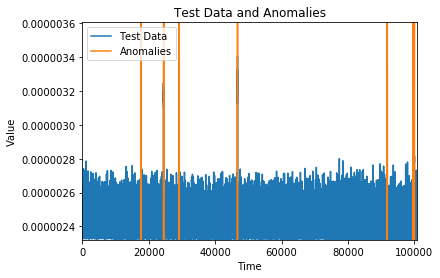

In [19]:
import matplotlib.pyplot as plt

# Scale the anomalies to match the height of the test data
scaled_anomalies = anomalies * test_data.max()

# Plot test_data
plt.plot(test_data, label='Test Data')

# Plot scaled anomalies
plt.plot(scaled_anomalies, label='Anomalies')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Test Data and Anomalies')

# Set x-axis limits
plt.xlim(test_data.index.min(), test_data.index.max())

# Set y-axis limits
plt.ylim(test_data.min(), test_data.max())

# Add legend
plt.legend()

# Show the plot
plt.show()

In [20]:
import numpy as np

if isinstance(anomalies, np.ndarray) and anomalies.dtype == bool:
    print("anomalies is a numpy array of booleans")
else:
    print("anomalies is not a numpy array of booleans")

anomalies is a numpy array of booleans


Threshold: 0.1, Precision: 0.009078777537135482, Recall: 0.570054945054945, F1 Score: 0.017872908546695668
	Augmented Precision: 0.01581783417347471, Augmented Recall: 1.0, Augmented F1 Score: 0.031143052703627654
Threshold: 0.125, Precision: 0.009209173409629397, Recall: 0.5659340659340659, F1 Score: 0.018123432894910484
	Augmented Precision: 0.01615838771252275, Augmented Recall: 1.0, Augmented F1 Score: 0.031802891966274956
Threshold: 0.15000000000000002, Precision: 0.009316131978536363, Recall: 0.5604395604395604, F1 Score: 0.01832760595647194
	Augmented Precision: 0.0165023234727417, Augmented Recall: 1.0, Augmented F1 Score: 0.03246883571571929
Threshold: 0.17500000000000002, Precision: 0.00946894605499452, Recall: 0.5576923076923077, F1 Score: 0.018621717692925126
	Augmented Precision: 0.01685224195004514, Augmented Recall: 1.0, Augmented F1 Score: 0.033145901154187626
Threshold: 0.2, Precision: 0.009565155165422322, Recall: 0.5508241758241759, F1 Score: 0.018803779512789852
	Au

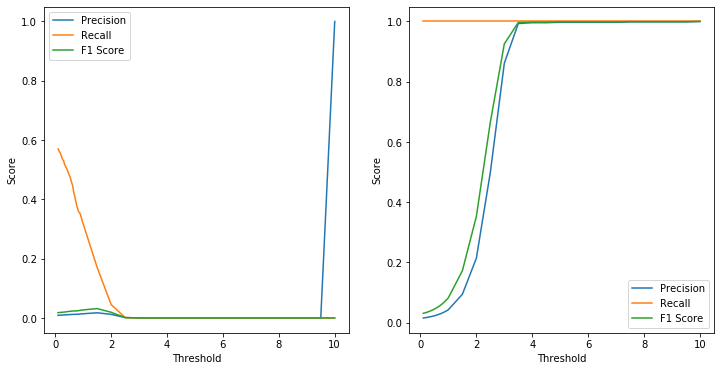

Best threshold: 1.5
Best precision: 0.017479560191711305
Best recall: 0.17032967032967034
Best F1: 0.03170544617744822
Best threshold (augmented): 10.0
Best precision (augmented): 1.0
Best recall (augmented): 1.0
Best F1 (augmented): 1.0


In [21]:
best_threshold, best_precision, best_recall, best_f1, best_threshold_aug, best_precision_aug, best_recall_aug, best_f1_aug = \
    vae_lstm.evaluate(test_data, anomalies, plot=True)

print(f"Best threshold: {best_threshold}")
print(f"Best precision: {best_precision}")
print(f"Best recall: {best_recall}")
print(f"Best F1: {best_f1}")
print(f"Best threshold (augmented): {best_threshold_aug}")
print(f"Best precision (augmented): {best_precision_aug}")
print(f"Best recall (augmented): {best_recall_aug}")
print(f"Best F1 (augmented): {best_f1_aug}")

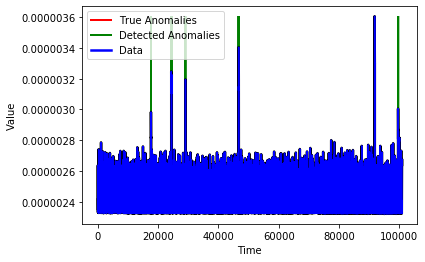

In [22]:
vae_lstm.plot_anomaly(test_data, best_threshold, None)

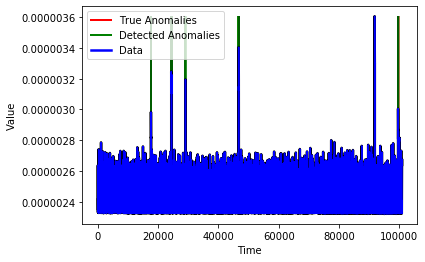

In [23]:
vae_lstm.plot_anomaly(test_data, best_threshold, anomalies)